# Few-shot-learning using swin_v2_t pretrained model

In [25]:
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

import matplotlib.pyplot as plt
from PIL import Image

from easyFSL_helper import *
from dataset_helper import *

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


In [56]:
dataset_path = 'animals_dataset'
labelmap_path = 'animals_label_map.json'

if dataset_path.__contains__('animals'):
    cmap = 'Blues'
else:
    cmap = 'PuRd'

N = 20 # n_classes
K = 5  # n_support_images
n_query = 10

In [57]:
val_transform = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [58]:
batch_size = 128
loss_module = nn.CrossEntropyLoss()

class_data = ClassData.get_class_data(dataset_path, labelmap_path, val_transform)
dataset = CustomDataset(class_data)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model = models.swin_v2_t(weights=models.Swin_V2_T_Weights.IMAGENET1K_V1)

model.head = nn.Flatten()

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [59]:
embeddings_df = predict_embeddings(data_loader, model, device=device)

print(embeddings_df.head())

Predicting embeddings:   0%|          | 0/3 [00:00<?, ?batch/s]

                                           embedding  class_name
0  [tensor(0.8127), tensor(0.5304), tensor(0.0944...           0
1  [tensor(-0.9640), tensor(-0.8917), tensor(0.10...           0
2  [tensor(0.1669), tensor(1.1028), tensor(-0.196...           0
3  [tensor(0.3772), tensor(0.4128), tensor(-0.052...           0
4  [tensor(0.4387), tensor(-1.6160), tensor(0.004...           0


In [60]:
features_dataset = FeaturesDataset.from_dataframe(embeddings_df)

In [61]:
task_sampler = TaskSampler(features_dataset, n_way=N, n_shot=K, n_query=n_query, n_tasks=100)

features_loader = DataLoader(features_dataset, batch_sampler=task_sampler, pin_memory=True, collate_fn=task_sampler.episodic_collate_fn)

In [62]:
few_shot_classifier = PrototypicalNetworks(backbone=nn.Identity())

In [63]:
accuracy, _, macro_precision, macro_recall, f1, cm = evaluate(few_shot_classifier, loss_module, features_loader, device="cpu")

print(f"Average accuracy : {(100 * accuracy):.6f} %\n",
      f"Macro precision: {(100 * macro_precision):.6f} %\n",
      f"Macro recall: {(100 * macro_recall):.6f} %\n",
      f"f1: {f1}")

  0%|          | 0/100 [00:00<?, ?it/s]

Average accuracy : 89.495000 %
 Macro precision: 90.029724 %
 Macro recall: 89.495000 %
 f1: 0.897615655705928


In [64]:
import seaborn as sns
def plot_confusion_matrix(cm: np.ndarray, class_names: List[str]):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

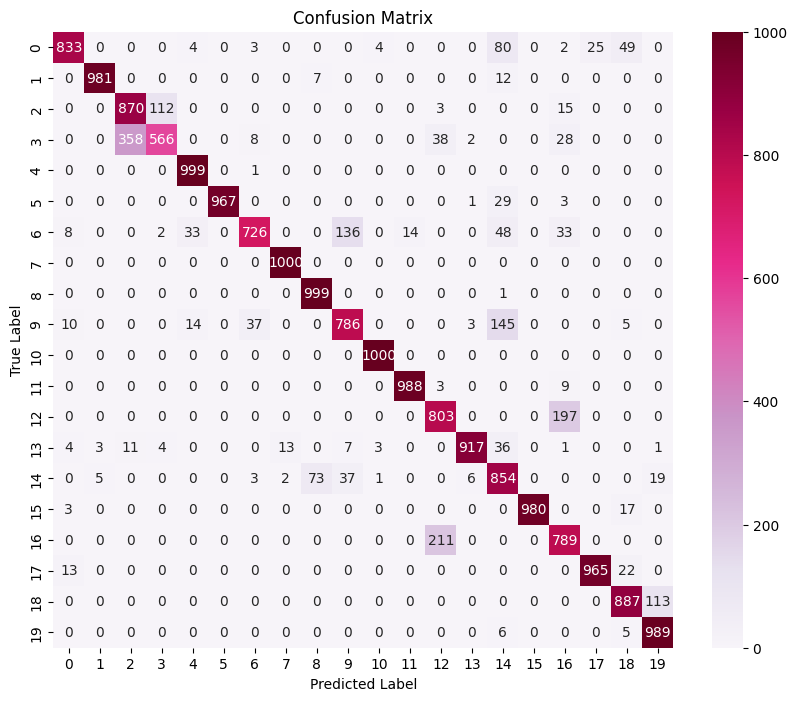

In [65]:
plot_confusion_matrix(cm, set(dataset.labels))

##### 5 way 5 shot: 
Average accuracy : 97.260000 % \
Macro precision: 97.272267 % \
Macro recall: 97.260000 % \
Loss: 1.44449902465567 \
f1: 1.8919015200000004

##### 10 way 5 shot:
Average accuracy : 95.350000 % \
Macro precision: 95.358749 %\
Macro recall: 95.350000 %\
Loss: 5.1830960139632225\
f1: 1.8183244999999992

##### 20 way 5 shot:
Average accuracy : 89.060000 % \
Macro precision: 89.385138 %\
Macro recall: 89.060000 %\
Loss: 20.561820646127064\
f1: 1.5863367200000003

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


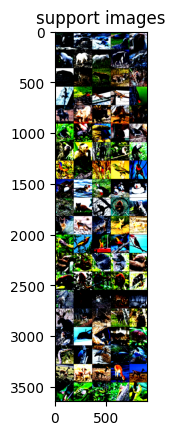

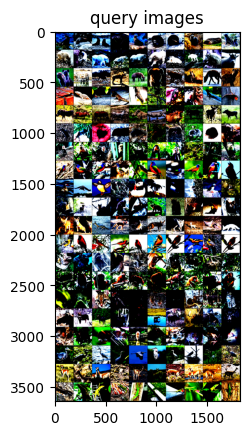

In [66]:
import torchvision

def plot_images(images: Tensor, title: str, images_per_row: int):
    plt.figure()
    plt.title(title)
    plt.imshow(torchvision.utils.make_grid(images, nrow=images_per_row).permute(1, 2, 0))


dataset.get_labels = lambda: [instance for instance in dataset.labels]

task_sampler = TaskSampler(dataset, n_way=N, n_shot=K, n_query=n_query, n_tasks=100)
support_loader =  DataLoader(dataset, batch_sampler=task_sampler, pin_memory=True, collate_fn=task_sampler.episodic_collate_fn)

(support_images, support_labels, query_images, query_labels, class_ids,) = next(iter(support_loader))

plot_images(support_images, "support images", images_per_row=K)
plot_images(query_images, "query images", images_per_row=n_query)